<a href="https://colab.research.google.com/github/prathammehta16/GAN/blob/main/GAN_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

try:
    
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np
import os
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [5]:

tf.random.set_seed(42)
np.random.seed(42)

In [6]:

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 19s 8ms/step - loss: 0.6600 - rounded_accuracy: 0.5966 - val_loss: 0.5991 - val_rounded_accuracy: 0.6868
Epoch 2/20
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5408 - rounded_accuracy: 0.7205 - val_loss: 0.5099 - val_rounded_accuracy: 0.7355
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4992 - rounded_accuracy: 0.7433 - val_loss: 0.4957 - val_rounded_accuracy: 0.7461
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4883 - rounded_accuracy: 0.7533 - val_loss: 0.4853 - val_rounded_accuracy: 0.7575
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4756 - rounded_accuracy: 0.7673 - val_loss: 0.4697 - val_rounded_accuracy: 0.7729
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4562 - rounded_accuracy: 0.7851 - val_loss: 0.4468 - val_rounded_accuracy: 0.7941
Epoch 7/20
1719/1719 [================

In [7]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 117ms/step
Saving figure reconstruction_plot


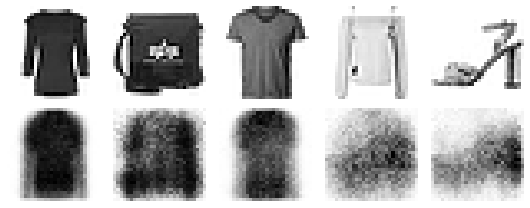

In [8]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

In [9]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 2ms/step


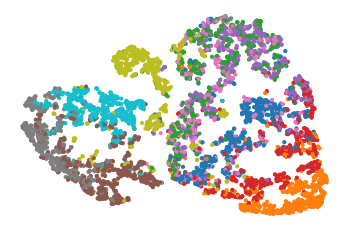

In [10]:

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [11]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [12]:

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
                                        keras.layers.Flatten(input_shape=[28, 28]),
                                        dense_1,
                                        dense_2
])
tied_decoder = keras.models.Sequential([
                                        DenseTranspose(dense_2, activation="selu"),
                                        DenseTranspose(dense_1, activation="sigmoid"),
                                        keras.layers.Reshape([28, 28])
])
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer = keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6663 - rounded_accuracy: 0.5975 - val_loss: 0.6252 - val_rounded_accuracy: 0.6691
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5740 - rounded_accuracy: 0.7138 - val_loss: 0.5388 - val_rounded_accuracy: 0.7356
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5213 - rounded_accuracy: 0.7486 - val_loss: 0.5085 - val_rounded_accuracy: 0.7572
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4954 - rounded_accuracy: 0.7682 - val_loss: 0.4858 - val_rounded_accuracy: 0.7736
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4737 - rounded_accuracy: 0.7803 - val_loss: 0.4650 - val_rounded_accuracy: 0.7831
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4523 - rounded_accuracy: 0.7892 - val_loss: 0.4434 - val_rounded_accuracy: 0.7916
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 83ms/step


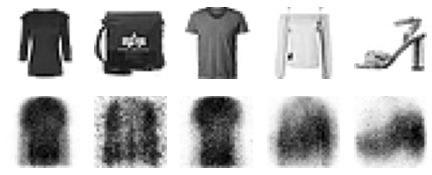

In [13]:
show_reconstructions(tied_ae)
plt.show()

In [14]:

tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 18s 7ms/step - loss: 0.5860 - rounded_accuracy: 0.6940 - val_loss: 0.4897 - val_rounded_accuracy: 0.7688
Epoch 2/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4033 - rounded_accuracy: 0.8522 - val_loss: 0.3742 - val_rounded_accuracy: 0.8719
Epoch 3/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3623 - rounded_accuracy: 0.8764 - val_loss: 0.3552 - val_rounded_accuracy: 0.8801
Epoch 4/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3472 - rounded_accuracy: 0.8845 - val_loss: 0.3431 - val_rounded_accuracy: 0.8882
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3370 - rounded_accuracy: 0.8925 - val_loss: 0.3346 - val_rounded_accuracy: 0.8959


1/1 [==============================] - 0s 230ms/step


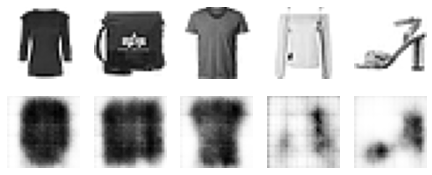

In [15]:
show_reconstructions(conv_ae)
plt.show()

In [16]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size=30

generator = keras.models.Sequential([
                                     keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
                                     keras.layers.Dense(150, activation="selu"),
                                     keras.layers.Dense(28 * 28, activation="sigmoid"),
                                     keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
                                         keras.layers.Flatten(input_shape=[28, 28]),
                                         keras.layers.Dense(150, activation="selu"),
                                         keras.layers.Dense(100, activation="selu"),
                                         keras.layers.Dense(1, activation="sigmoid"),
])
gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [18]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [19]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [20]:

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))             
        for X_batch in dataset:
           
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
           
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                
        plt.show()               

Epoch 1/1


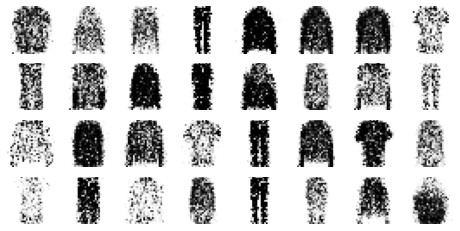

In [21]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [23]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [24]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. 

In [25]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


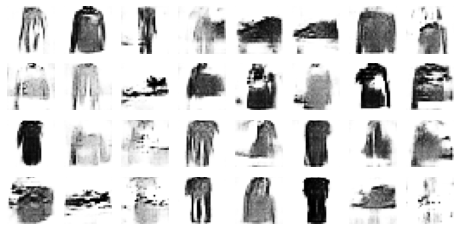

Epoch 2/50


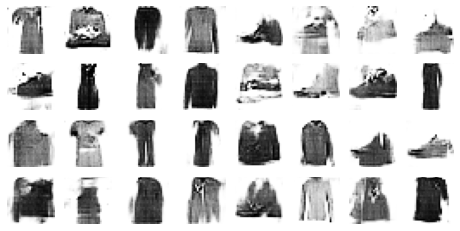

Epoch 3/50


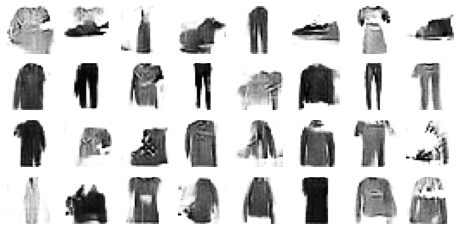

Epoch 4/50


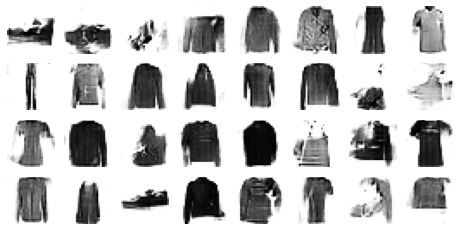

Epoch 5/50


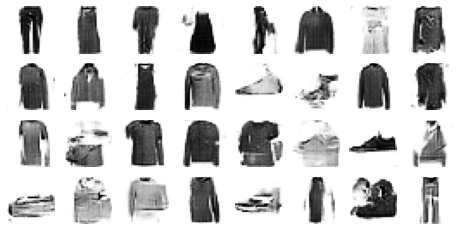

Epoch 6/50


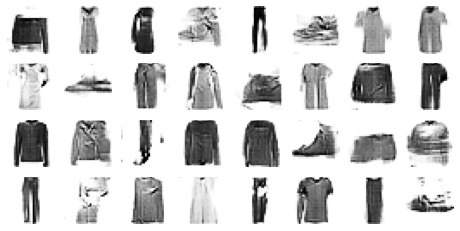

Epoch 7/50


KeyboardInterrupt: ignored

In [26]:
train_gan(gan, dataset, batch_size, codings_size)